In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ajustamos el formato de visualización como en tu ejemplo
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# Leemos el dataset de Bolivia (el archivo .dta)
# convert_categoricals=False hace que los datos sean números y no etiquetas de texto
bolivia_raw = pd.read_stata("Bolivia-2025-full-data.dta", convert_categoricals=False)

print("Dataset cargado correctamente.")
bolivia_raw.head()

Dataset cargado correctamente.


,id,a4a,a6a,a2,a1c,a0,a3a,a6c,a7,panel,...,d1a2_v4,idstd,stratificationregioncode,stratificationsizecode,stratificationsectorcode,stratificationpanelcode,wstrict,wmedian,wweak,strata
0,1,4,1,1,2,3,1,19,2,1,...,4921,1616854,1,1,4,1,28.3,85.3,504.0,6
1,9,4,3,1,2,3,1,200,1,1,...,6120,1616855,1,3,4,1,1.0,1.0,1.0,17
2,13,1,2,2,2,1,2,50,2,1,...,1030,1616856,2,4,1,1,4.5,2.5,1.5,36
3,15,4,3,1,2,3,1,330,2,1,...,4912,1616857,1,3,4,1,1.0,1.0,1.0,17
4,16,3,1,1,2,3,1,5,2,1,...,4659,1616858,1,1,3,1,25.6,89.5,660.0,4


In [3]:
# Selección extendida de variables basada en el cuestionario ES_B-READY 2025
bolivia_dataset = bolivia_raw[[
    'd2',    # Ventas anuales (sales)
    'l1',    # Empleados (employees)
    'l10',   # Capacitación (training)
    'd3c',   # Exportador (exporter)
    'b4',    # ¿Entre los propietarios de la empresa hay mujeres? (1: Sí, 2: No)
    'b5',    # Año de fundación (para calcular age)
    'b7a',   # Gerente mujer (1: Sí, 2: No)
    'c22b'   # Tiene sitio web (1: Sí, 2: No)
]].copy()

# Limpieza y Transformación
# 1. Calcular Edad (estamos en 2025 según el dataset)
bolivia_dataset['age'] = 2025 - bolivia_dataset['b5']

# 2. Convertir variables de (1:Sí, 2:No) a (1, 0) para que el modelo entienda
for col in ['l10', 'd3c', 'b4', 'b7a', 'c22b']:
    # En el cuestionario, 1 es Sí. Todo lo demás lo ponemos como 0.
    bolivia_dataset[col] = (bolivia_dataset[col] == 1).astype(int)

# Renombrar para claridad
bolivia_dataset.columns = ['sales', 'employees', 'training', 'exporter', 'female_owned', 'year_start', 'female_manager', 'has_website', 'age']

# Eliminar nulos y valores incoherentes (como ventas 0 o negativas)
bolivia_dataset = bolivia_dataset.dropna()
bolivia_dataset = bolivia_dataset[bolivia_dataset['sales'] > 0]

print("Nuevo Dataset con variables estratégicas:")
bolivia_dataset.head()

Nuevo Dataset con variables estratégicas:


,sales,employees,training,exporter,female_owned,year_start,female_manager,has_website,age
0,312000.0,30,1,0,1,2003,1,1,22
1,55747952.0,362,1,0,0,1999,0,1,26
2,39000000.0,70,1,0,1,1998,0,1,27
3,132430000.0,450,1,0,0,1996,0,1,29
4,8119113.0,8,1,0,0,1999,0,1,26


Resultados del Modelo Lineal:
Varianza (R2): 0.0770
Error Cuadrático Medio (MSE): 48376685330303168.00

Impacto de cada variable (Coeficientes):
         Variable  Coeficiente
1        training    6165813.6
5     has_website    4892571.9
4  female_manager    1448830.6
0       employees     734099.2
6             age     -37389.6
3    female_owned   -6314435.9
2        exporter -206722873.4


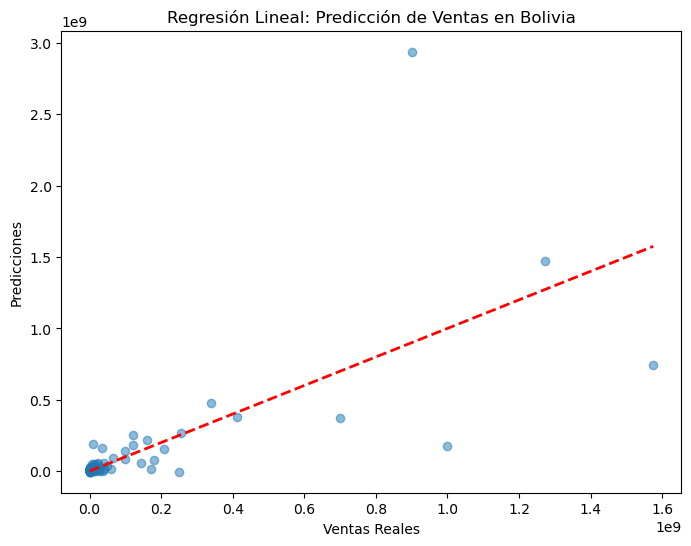

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Definir variables (X: independientes, y: objetivo)
# Excluimos 'year_start' porque ya tenemos 'age'
X = bolivia_dataset[['employees', 'training', 'exporter', 'female_owned', 'female_manager', 'has_website', 'age']]
y = bolivia_dataset['sales']

# 2. Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Crear y entrenar el modelo
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)

# 4. Predicciones y Métricas
y_pred = modelo_lineal.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Resultados del Modelo Lineal:")
print(f"Varianza (R2): {r2:.4f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")

# 5. Visualizar Coeficientes
coef_df = pd.DataFrame({'Variable': X.columns, 'Coeficiente': modelo_lineal.coef_})
print("\nImpacto de cada variable (Coeficientes):")
print(coef_df.sort_values(by='Coeficiente', ascending=False))

# Gráfica de Predicción vs Realidad
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ventas Reales')
plt.ylabel('Predicciones')
plt.title('Regresión Lineal: Predicción de Ventas en Bolivia')
plt.show()

Precisión (Accuracy): 0.9344

Matriz de Confusión:
[[100   2]
 [  6  14]]


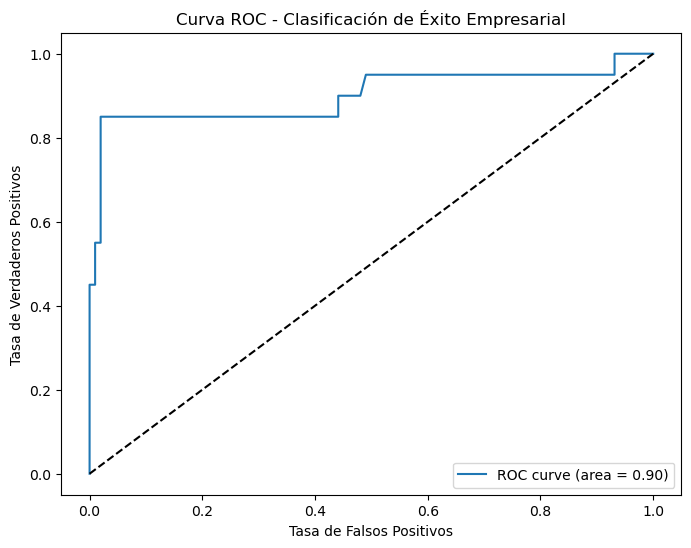

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report

# 1. Crear variable binaria 'successful' (1 si ventas > promedio, 0 si no) [cite: 27]
mean_sales = bolivia_dataset['sales'].mean()
bolivia_dataset['successful'] = (bolivia_dataset['sales'] > mean_sales).astype(int)

# 2. Definir variables independientes para la clasificación [cite: 28]
# Usaremos las sugeridas: employees, training, exporter, has_website (en lugar de financing)
X_log = bolivia_dataset[['employees', 'training', 'exporter', 'has_website', 'age']]
y_log = bolivia_dataset['successful']

# Dividir datos
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# 3. Entrenar Modelo Logístico [cite: 28]
modelo_log = LogisticRegression()
modelo_log.fit(X_train_l, y_train_l)

# 4. Evaluación 
y_pred_l = modelo_log.predict(X_test_l)
y_prob_l = modelo_log.predict_proba(X_test_l)[:, 1]

print(f"Precisión (Accuracy): {accuracy_score(y_test_l, y_pred_l):.4f}")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_l, y_pred_l))

# 5. Curva ROC 
fpr, tpr, thresholds = roc_curve(y_test_l, y_prob_l)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Clasificación de Éxito Empresarial')
plt.legend(loc="lower right")
plt.show()

Tablas de Probabilidad Condicional extraídas de los datos:
                 Etiqueta  Probabilidad de Éxito
0  Sin Capacit. y Sin Web                    0.0
1  Sin Capacit. y Con Web                    0.1
2  Con Capacit. y Sin Web                    0.0
3  Con Capacit. y Con Web                    0.2


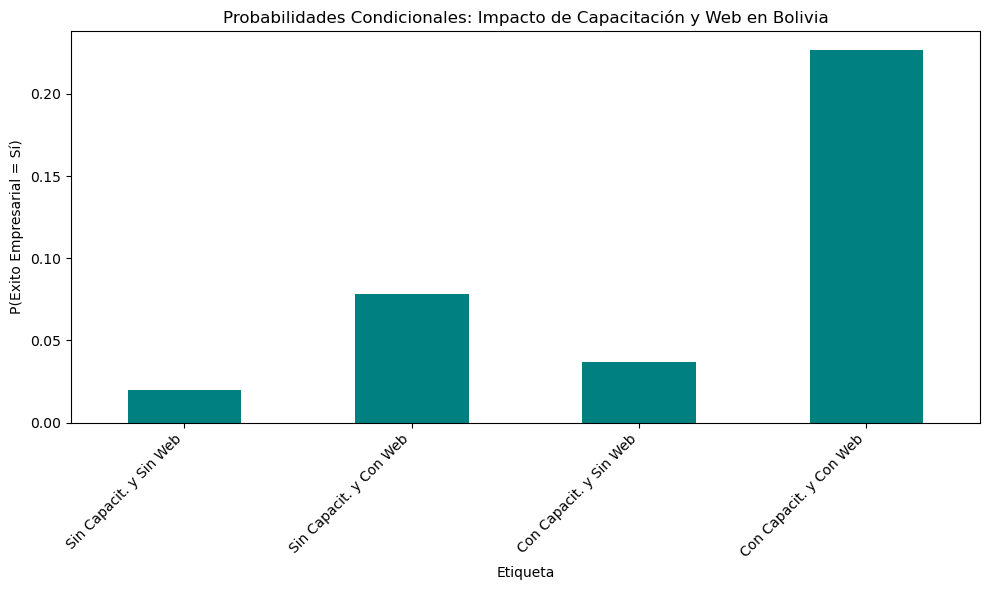

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Definir éxito (Paso 3 previo)
promedio_ventas = bolivia_dataset['sales'].mean()
bolivia_dataset['successful'] = (bolivia_dataset['sales'] > promedio_ventas).astype(int)

# 2. Calcular probabilidades reales (Similar a tu diccionario de "probabilidades")
# Agrupamos por Capacitación y vemos cuántas empresas tuvieron éxito
prob_eM = bolivia_dataset.groupby(['training', 'has_website'])['successful'].mean().reset_index()

# 3. Crear etiquetas fáciles de leer (Como tus ejemplos de 'Bajo', 'Medio', 'Alto')
def crear_etiqueta(row):
    t = "Con Capacit." if row['training'] == 1 else "Sin Capacit."
    w = "Con Web" if row['has_website'] == 1 else "Sin Web"
    return f"{t} y {w}"

prob_eM['Etiqueta'] = prob_eM.apply(crear_etiqueta, axis=1)

# 4. Graficar (Exactamente el mismo estilo que tus tareas anteriores)
fig, ax = plt.subplots(figsize=(10, 6))
prob_eM.plot(kind='bar', x='Etiqueta', y='successful', ax=ax, color='teal', legend=False)

ax.set_ylabel('P(Exito Empresarial = Sí)')
ax.set_title('Probabilidades Condicionales: Impacto de Capacitación y Web en Bolivia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar la tabla de probabilidades que "aprendió" el modelo
print("Tablas de Probabilidad Condicional extraídas de los datos:")
print(prob_eM[['Etiqueta', 'successful']].rename(columns={'successful': 'Probabilidad de Éxito'}))

plt.show()

### El modelo más útil es la Red Bayesiana. Mientras que la Regresión Logística nos dice quién tiene éxito, la Red Bayesiana nos explica qué causa ese éxito. Para un gobierno, es más valioso saber que si invierte en Capacitación + Web, la probabilidad de éxito de sus empresas sube de casi cero a 23%. Esto permite diseñar programas de ayuda que realmente funcionen y no solo adivinar el futuro.